<a href="https://colab.research.google.com/github/law0/face_detect/blob/main/face_detect_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
req = """# Python 3.7.5
onnx>=1.7.0
numpy>=1.19.1

torch>=1.5.1
torchvision>=0.6.1

tensorflow>=2.1.0
tensorflow-gpu>=2.1.0"""

f = open("requirements.txt", "w")
f.write(req)
f.close()

In [23]:
!pip install -r requirements.txt

In [24]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import widerface
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
import copy
import pandas
import requests
import zipfile
from math import ceil
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
batch_size_train = 64
batch_size_test = 1
img_dim = 224

def detection_collate(batch):
  """Custom collate fn for dealing with batches of images that have a different
  number of associated object annotations (bounding boxes).
  Arguments:
      batch: (tuple) A tuple of tensor images and lists of annotations
  Return:
      A tuple containing:
          1) (tensor) batch of images stacked on their 0 dim
          2) (list of tensors) annotations for a given image are stacked on 0 dim
  """
  transform_resize = transforms.Resize((img_dim, img_dim))
  targets = []
  imgs = []
  for _, sample in enumerate(batch):
    img, annot = sample
    orig_h = img.shape[1]
    orig_w = img.shape[2]
    img = transform_resize(img)
    imgs.append(img)

    target = torch.tensor(annot['bbox']).float()
    target[:,0] = target[:,0] / orig_w * img_dim
    target[:,2] = target[:,2] / orig_w * img_dim

    target[:,1] = target[:,1] / orig_h * img_dim
    target[:,3] = target[:,3] / orig_h * img_dim
    targets.append(target)

  return (torch.stack(imgs, 0), targets)

In [27]:
train_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "train", download=True,
                             transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

val_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "val", download=True,
                              transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

test_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace('./', "test", download=True,
                             transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_test, shuffle=True, collate_fn=detection_collate)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


175.65625 60.40449523925781 19.25 41.707862854003906
167.125 21.573034286499023 18.375 38.47190856933594
118.34375 22.65168571472168 17.71875 37.03370666503906
68.90625 47.82022476196289 18.59375 37.03370666503906
43.96875 36.314605712890625 15.75 43.505619049072266


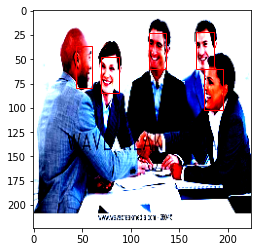

In [28]:
images, targets = next(iter(train_loader))

fig, ax = plt.subplots()

ax.imshow(images[0].permute(1, 2, 0))

num_targets = targets[0].shape[0]
for i in range(num_targets):
  #x,y represent bottom left corner
  x = targets[0][i][0]
  y = targets[0][i][1]
  w = targets[0][i][2]
  h = targets[0][i][3]
  print("{} {} {} {}".format(x, y, w, h))
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()

In [29]:
class ResnetGrid7x7(nn.Module):
    def __init__(self, resnet=models.resnet18(pretrained=True)):
      super(ResnetGrid7x7, self).__init__()
      self.resnet = resnet
      self.resnet.fc = nn.Linear(512, 49*5) # 7 * 7 * ((x,y,w,h) + confidence)
      self.sigmo = nn.Sigmoid()
      
    def forward(self, x):
      return self.sigmo(self.resnet(x))

In [30]:
def getResponsibleCells(targets):
  # 224 / 7 = 32

  """return list (of len batch_size)
  of tuples of tensor.
  Each tuples contains:
    - A tensor of size (num_targets)
      containing which cell (from 0 to 49)
      is responsible for the box.
      -1 means not found
    - A tensor of size (49, 4)
      containing : 
      the box the aformentioned cell is responsible of at the cell index
      OR a fake box of size of the image if no box is assigned to the cell"""

  out = []
  batch_size = len(targets)
  for j in range(batch_size):
    num_targets = targets[j].shape[0]
    out_cell = - torch.ones(num_targets)
    out_box = torch.zeros((49, 4))
    for k in range(num_targets):
      target = targets[j][k]
      center_x = target[0] + target[2]/2
      center_y = target[1] + target[3]/2
      for i in range(49):
        cell_x = (i % 7) * 32
        cell_y = (i / 7) * 32
        #Y axes is going down
        if cell_x <= center_x and center_x < cell_x + 32 and cell_y >= center_y and center_y > cell_y - 32:
          out_cell[k] = i
          out_box[i] = target.float() / img_dim
        else:
          out_box[i] = torch.tensor((0., 0., 1., 1.))
    out.append((out_cell.long(), out_box))
    
  return out #(batch_size, num_targets)

class PseudoYolo7x7Loss(nn.Module):
    def __init__(self, alpha):
      super(PseudoYolo7x7Loss, self).__init__()
      self.alpha = alpha
      self.bce_loss = nn.BCELoss()
      self.mse_loss = nn.MSELoss()

    def forward(self, predictions, targets):
      preds = predictions.view(-1, 49, 5)
      batch_size = preds.shape[0]

      preds_confs = preds[:,:,0]
      preds_boxes = preds[:,:,1:]

      responsible_cells = getResponsibleCells(targets)
      target_confs_list = []
      target_boxes_list = []
      for cell_indexes, boxes in responsible_cells:
        multi_hot = torch.zeros(49)
        multi_hot[cell_indexes] = 1
        target_confs_list.append(multi_hot)
        target_boxes_list.append(boxes)

      targets_confs = torch.stack(target_confs_list, 0)
      targets_boxes = torch.stack(target_boxes_list, 0)

      preds_confs = preds_confs.to(device)
      preds_boxes = preds_boxes.to(device)
      targets_confs = targets_confs.to(device)
      targets_boxes = targets_boxes.to(device)

      c_loss = self.bce_loss(preds_confs, targets_confs)
      b_loss = self.mse_loss(preds_boxes, targets_boxes)
      return b_loss + self.alpha * c_loss
      

In [34]:
model = ResnetGrid7x7()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = PseudoYolo7x7Loss(0.1)

model.to(device)
for i, (images, targets) in enumerate(train_loader):
  images = images.to(device)
  targets = [anno.to(device) for anno in targets]

  optimizer.zero_grad()

  out = model(images)
  loss = criterion(out, targets)
  loss.backward()
  optimizer.step()

  if i % 10 == 0:
    print(loss.item())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.33414873480796814
0.33232101798057556
0.33098581433296204
0.3313322961330414
0.3299010694026947
0.3270488977432251
0.32743555307388306
0.32502877712249756
0.3246351480484009
0.32455363869667053
0.32246845960617065
0.32276681065559387
0.3204980790615082
0.3190954923629761
0.31844377517700195
0.3167273700237274
0.3161976635456085
0.316366046667099
0.3150627017021179
0.3130781650543213
0.3115079998970032
